<a href="https://colab.research.google.com/github/binarykisu/MachineLearning_projects/blob/main/binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification of data

The goal of this project/assignment is to create a binary classification dataset with Scikit-Learn's `make_moons()` function.

## 1. Classifying and preparing some data

In [37]:
import torch
import sklearn
from sklearn.datasets import make_moons
import numpy as np
torch.__version__

'2.1.0+cu121'

In [38]:
# Setup device-agnostic code in case working on a GPU is preferrable
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [39]:
# Using 1000 data samples and setting the random seed to 5
num_samples = 1000
X, y = make_moons(n_samples=num_samples, noise=0.03, random_state=5) # From sklearn; Makes two interleaving half circles.

More on this function from `sklearn`: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

In [40]:
len(X), len(y)

(1000, 1000)

In [41]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}") # Binary classification: 0 or 1

First 5 samples of X:
 [[ 0.11135294  0.24393462]
 [ 0.02923245  0.41314213]
 [ 0.31333961  0.91421851]
 [ 1.05870435  0.03687264]
 [-0.17115502  1.0023207 ]]
First 5 samples of y:
 [1 1 0 0 0]


In [42]:
import pandas as pd # Make a dataframe with pandas of moon data

moons = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})
moons.head(10)

,X1,X2,label
0,0.111353,0.243935,1
1,0.029232,0.413142,1
2,0.313340,0.914219,0
3,1.058704,0.036873,0
4,-0.171155,1.002321,0
5,0.356626,-0.309477,1
6,0.357277,-0.242852,1
7,1.075479,-0.497869,1
8,0.275035,0.949041,0
9,0.822188,-0.501551,1


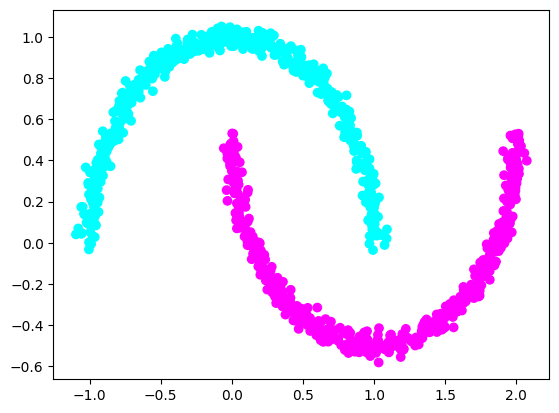

In [43]:
# Visualize the data so far
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap="cool")

In [44]:
# View the first sample of features and lables
X_sample = X[0]
y_sample = y[0]
print(f"One sample of X: {X_sample} and one sample of y: {y_sample}")
print(f"Shape for one sample of X: {X_sample.shape} and one sample of y: {y_sample.shape}") # There should be 2 features of X, 1 number (scalar) of y

One sample of X: [0.11135294 0.24393462] and one sample of y: 1
Shape for one sample of X: (2,) and one sample of y: ()


In [45]:
# Now it's time to turn data into torch tensors (currently an np array)
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X[:5], y[:5]

(tensor([[ 0.1114,  0.2439],
         [ 0.0292,  0.4131],
         [ 0.3133,  0.9142],
         [ 1.0587,  0.0369],
         [-0.1712,  1.0023]]),
 tensor([1., 1., 0., 0., 0.]))

In [46]:
# Split data into training and test sets using sklearn
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be testing, 80% of data will be for training
                                                    random_state=5) # For reproducibility

In [48]:
len(X_train), len(X_test), len(y_train), len(y_test) # Confirm the number of samples being tested/trained

(800, 200, 800, 200)

## 2. Building a model

Building a model to classiy the data.

1. Setup device-agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [49]:
# 1. Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

For this model, I will:
- Create three `nn.Linear()` layers
- Create one non-linear `nn.ReLU()` layer
- Define a `forward()` method that outlines the forward pass
- Create an instance of the model class and send it to the target device

In [50]:
# 2. Build a model with non-linear activation functions
from torch import nn
class MoonModel(nn.Module):
  def __init__(self, input_features:int = 2, hidden_features:int = 10, output_features:int = 1): # 2 features of X -> 2 input features; 10 features/hidden layer
    super().__init__()
    self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_features) # Outer features of this layer must match the input features of the next layer
    self.layer_2 = nn.Linear(in_features=hidden_features, out_features=hidden_features)
    self.layer_3 = nn.Linear(in_features=hidden_features, out_features=output_features)
    self.relu = nn.ReLU() # The non-linear layer

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))) # A ReLU layer goes in-between each linear function!

model = MoonModel().to(device)
model

MoonModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [51]:
# 3. Setup a loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # Good for non-linear layers
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1) # Can adjust the learning rate as needed

In [52]:
# Create an accuracy function
def accuracy_fn(y_true, y_pred):
  """Calculates the accuracy with evaluation - true positive / (true positive + true negative) *100"""
  correct = torch.eq(y_true, y_pred).sum().item()
  accuracy = (correct / len(y_pred)) * 100
  return accuracy

## 3. Training and testing a model with non-linearity

In [53]:
# Creating a timer to see how fast the model runs
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
  """Prints difference between start and end times."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds.")
  return total_time

In [54]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

In [55]:
# 4. Creating a training and testing loop

# Set a random seed for reproducability
torch.manual_seed(5)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Set the epochs to loop through the data
epochs = 1000

# Starting the timer
start_time = timer()

for epoch in tqdm(range(epochs)):

  ### Training loop
  model.train()

  # Forward pass
  y_logits = model(X_train).squeeze() # Get rid of extra dimension
  y_predict = torch.round(torch.sigmoid(y_logits)) # Use sigmoid function to turn raw logits -> predictions

  # Calculate the loss
  loss = loss_fn(y_logits, y_train) # loss_fn =  BCEWithLogitsLoss
  accuracy = accuracy_fn(y_true=y_train,
                    y_pred=y_predict)

  # Optimizer zero grad
  optimizer.zero_grad()

  # Loss backwards
  loss.backward()

  # Optimizer step
  optimizer.step()

  ### Testing loop
  model.eval()
  with torch.inference_mode(): # Put model in inference mode when testing
    test_logits = model(X_test).squeeze() # Get rid of extra dimension
    test_predict = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test) # Loss of test data
    test_accuracy = accuracy_fn(y_true=y_test,
                           y_pred=test_predict)

  # Print out the results:
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.2f}%")

# Calculate total training time
end_time = timer()
total_train_time = print_train_time(start_time, end_time, device=str(next(model.parameters()).device))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.71194, Accuracy: 50.62% | Test loss: 0.71031, Test Accuracy: 47.50%
Epoch: 100 | Loss: 0.39730, Accuracy: 83.75% | Test loss: 0.42542, Test Accuracy: 82.50%
Epoch: 200 | Loss: 0.25052, Accuracy: 89.00% | Test loss: 0.29180, Test Accuracy: 86.00%
Epoch: 300 | Loss: 0.19805, Accuracy: 91.50% | Test loss: 0.23909, Test Accuracy: 88.50%
Epoch: 400 | Loss: 0.15845, Accuracy: 93.25% | Test loss: 0.19411, Test Accuracy: 89.00%
Epoch: 500 | Loss: 0.11692, Accuracy: 95.38% | Test loss: 0.14483, Test Accuracy: 93.00%
Epoch: 600 | Loss: 0.07666, Accuracy: 97.75% | Test loss: 0.09615, Test Accuracy: 96.50%
Epoch: 700 | Loss: 0.04777, Accuracy: 99.50% | Test loss: 0.06034, Test Accuracy: 99.00%
Epoch: 800 | Loss: 0.03085, Accuracy: 99.88% | Test loss: 0.03901, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.02129, Accuracy: 100.00% | Test loss: 0.02691, Test Accuracy: 100.00%
Train time on cpu: 2.129 seconds.


It looks like the model's accuracy improved a lot, even by the 300th epoch!

## 4. Evaluating the model

To evaluate the model visually, I'm going to import a function called `plot_decision_boundary()` from Daniel Bourke's GitHub repo: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py.



In [58]:
# Using the requests library to import this file
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download..")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


In [59]:
# Make predictions
model.eval() # Put model in eval mode

with torch.inference_mode():
  y_predict = torch.round(torch.sigmoid(model(X_test))).squeeze()

y_predict[:10], y_test[:10]

(tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 1.]),
 tensor([1., 0., 0., 1., 0., 0., 1., 0., 1., 1.]))

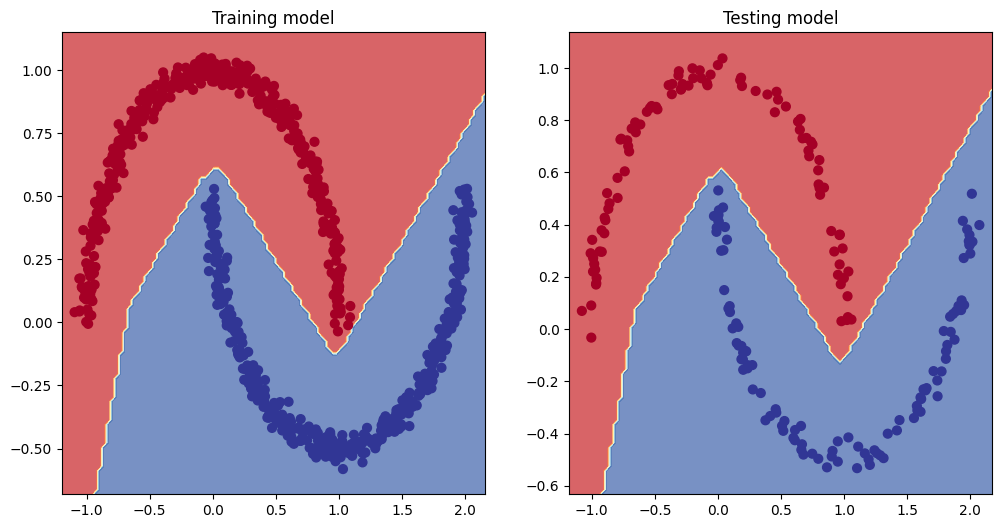

In [61]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) #(Rows, columns, index)
plt.title("Training model")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing model")
plot_decision_boundary(model, X_test, y_test)

It looks like the model did really well at classifying which semi-circle the data should belong to.